In [1]:
import pathlib

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import tqdm

from dataset_fetcher import download_loans
from real_games import multi_shapley_values, result_plots, plot_phi

In [2]:
sns.set_style('whitegrid')

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import the dataset
**NOTE:** The download URL has been removed from the `download_loans()` function, meaning this dataset cannot be downloaded and run with this version of the code.

In [4]:
data_dir = pathlib.Path('loan_dataset')
train_df, test_df = download_loans(data_dir)
figures_dir = pathlib.Path('figures')
with (figures_dir / '.gitignore').open('w') as gitignore:
    gitignore.write('*.png\n')

CPU times: user 30 ms, sys: 1.17 s, total: 1.2 s
Wall time: 1.84 s


# Get feature importances via fitting a boosted trees model

All features performance:
train auc: 0.727 | test auc: 0.692



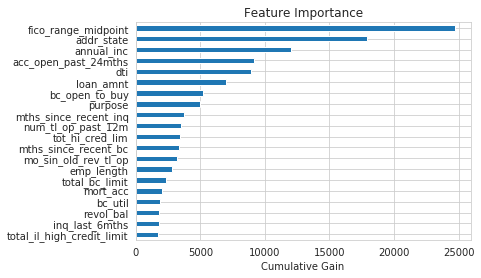

Selected features: ['fico_range_midpoint', 'addr_state', 'annual_inc', 'acc_open_past_24mths', 'dti']
Selected features performance:
train auc: 0.673 | test auc: 0.653



In [5]:
# fit and score the model
model = lgb.LGBMClassifier()
x_train = train_df.drop(columns=['charged_off'])
x_test = test_df.drop(columns=['charged_off'])
y_train = train_df['charged_off']
y_test = test_df['charged_off']
model.fit(x_train, y_train)
print(f'All features performance:'
      f'\ntrain auc: {sklearn.metrics.roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.3f}'
      f' | test auc: {sklearn.metrics.roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.3f}')
print()

importances = pd.Series(
    model.booster_.feature_importance('gain'), 
    index=train_df.drop(columns=['charged_off']).columns.tolist()
)
importances.sort_values()[-20:].plot('barh')
plt.xlabel('Cumulative Gain')
plt.title('Feature Importance')
plt.show()

# fit and score the top-features model
features = importances.sort_values(ascending=False).index.tolist()[:5]
print('Selected features:', features)
x_train = x_train.loc[:, features].copy()
x_test = x_test.loc[:, features].copy()
model.fit(x_train, y_train)
print(f'Selected features performance:'
      f'\ntrain auc: {sklearn.metrics.roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.3f}'
      f' | test auc: {sklearn.metrics.roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.3f}')
print()

# Explaining the model

## For context, plot the distributions of the model's inputs and outputs

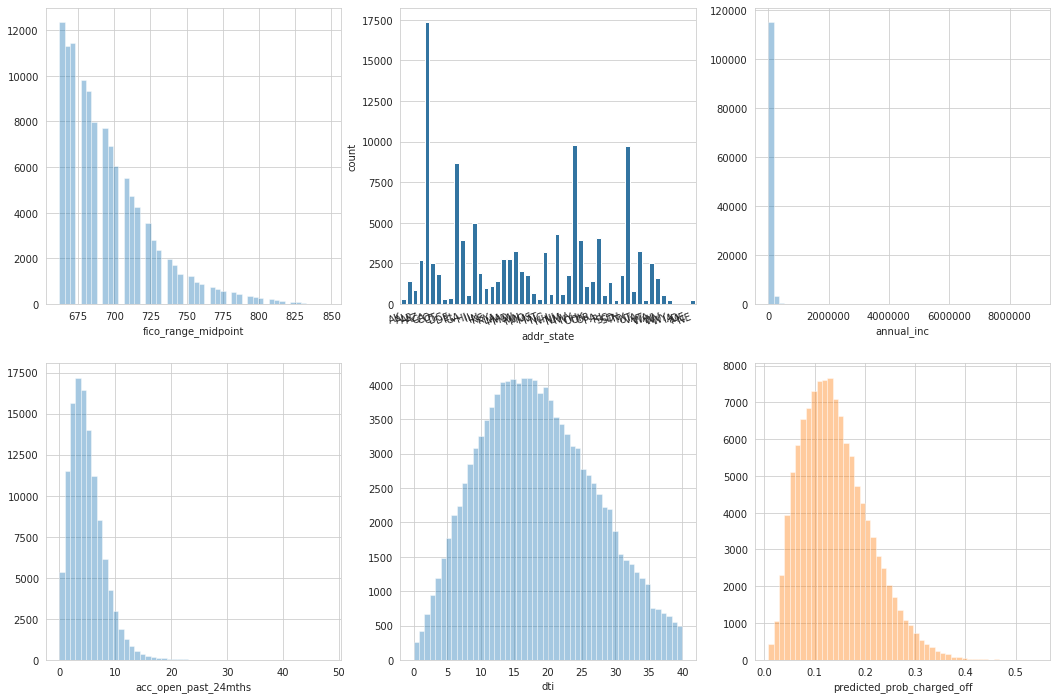

In [6]:
f, axes = plt.subplots(2,3, figsize=(18, 12),)
for i, column_name in enumerate(x_test):
    ax = axes[i//3, i%3]
    if x_test[column_name].dtype.name == 'category':
        sns.countplot(x=column_name, data=x_test, color=sns.color_palette()[0], ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
    else:
        sns.distplot(x_test[column_name], kde=False, ax=ax)
        
y_hat_test = pd.Series(model.predict_proba(x_test)[:, 1], index=x_test.index, name='predicted_prob_charged_off')
sns.distplot(y_hat_test, kde=False, ax=axes[1,2], color=sns.color_palette()[1])
f.savefig(figures_dir / 'loans_distributions.png', bbox_inches='tight')
plt.show()

## Find the loan rejection threshold

In [9]:
# reject 85% of applicants
rejection_threshold = y_hat_test.quantile(.15)

## Let's find a row with high prediction and try to understand why

In [10]:
idx = y_hat_test[x_test['annual_inc'].gt(100_000) & y_hat_test.gt(0.25)].index
low_pred_rows = pd.concat([x_test.loc[idx], y_hat_test.loc[idx]], axis=1)
model_input_id = 52038703
model_input_idx = np.where(x_test.index == model_input_id)[0][0]
model_input = x_test.iloc[model_input_idx:model_input_idx+1]
display(low_pred_rows.sample(20, random_state=0)
        .style
        .set_caption('Low Score')
        .apply(lambda x: ['background: lightsalmon' if x.name == model_input_id else '' for i in x], axis=1))

,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti,predicted_prob_charged_off
id,,,,,,
45534635,682,AL,150000,11,19.71,0.254518
55909943,677,MS,115000,13,25.4,0.338352
52038703,687,FL,600000,22,0.96,0.277184
46713316,667,TX,104000,16,30.35,0.340107
46753164,667,VA,114046,21,13,0.283713
54177508,702,CA,175000,14,27.85,0.334195
51907491,662,FL,110000,17,30.67,0.31071
49067556,662,TX,102999,24,19.9,0.377767
58542903,677,TX,135000,32,21.7,0.317257


In [11]:
# wow, tough luck, can't get $7,500 when you make $600,000!
test_df.loc[model_input_id, 'loan_amnt']

7500.0

## Playing n games (one per input)

pre-computing payout functions...


100%|██████████| 10000/10000 [00:00<00:00, 11736.40it/s]


computing shapley values...


100%|██████████| 10000/10000 [00:07<00:00, 1389.14it/s]


,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
mean,0.00427837,0.0304135,0.00438056,0.099419,-0.0027508
std,0.0225422,0.0350868,0.0285677,0.0320439,0.0412661


(-0.2, 0.25)

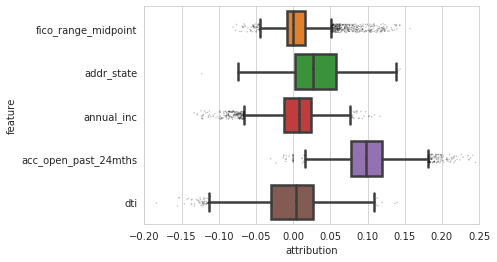

In [12]:
model_fn = lambda input_df: model.predict_proba(input_df)[:, 1]

x_test_sample = x_test.sample(10_000, random_state=0)
y_hat_test_sample = model_fn(x_test_sample)
phi_0, phi = multi_shapley_values(model_fn, model_input, x_test_sample)

phi_0_marginal, phi_marginal = phi_0, phi # save

display(phi.agg(['mean', 'std']).style.set_caption('Mean Attributions'))

# result_plots(phi_0, phi, fig_path=figures_dir, figname='loans_marginal')
plot_phi(phi)
plt.xlim(-.2, .25)

# Compare against accepted predictions

## Score <= rejection_threshold
What we really care about is why this individual was not granted a loan. Therefore, we compare against just the points which were accepted.

pre-computing payout functions...


100%|██████████| 10000/10000 [00:00<00:00, 13521.44it/s]


computing shapley values...


100%|██████████| 10000/10000 [00:07<00:00, 1345.59it/s]


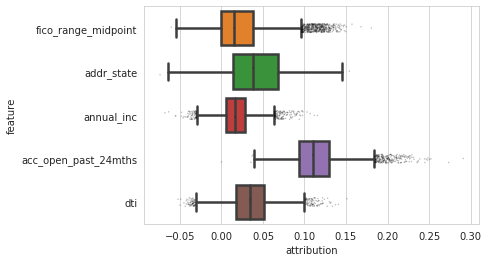

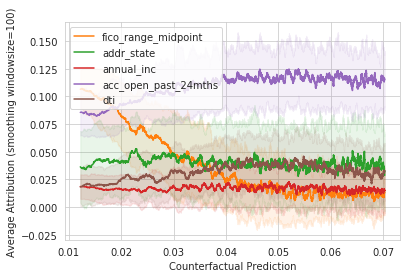

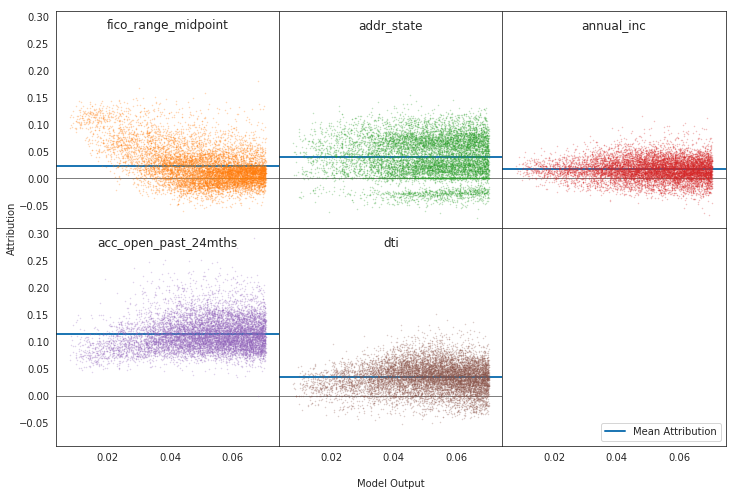

,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
mean,0.0224471,0.0390454,0.0167385,0.113713,0.034304
std,0.0338273,0.0366754,0.0191953,0.0288159,0.0258425


(-0.2, 0.25)

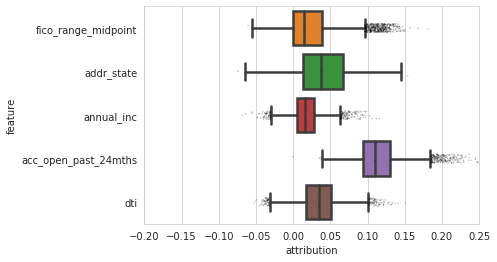

In [13]:
accepted_mask = y_hat_test.le(rejection_threshold)
accepted_input_sample = x_test[accepted_mask].sample(10_000, random_state=0)

phi_0_accepted, phi_accepted = multi_shapley_values(model_fn, model_input, accepted_input_sample)
result_plots(phi_0_accepted, phi_accepted, fig_path=figures_dir, figname='loans_vs_accepted')

display(phi_accepted.agg(['mean', 'std']).style.set_caption('Mean Attributions'))

plot_phi(phi_accepted)
plt.xlim(-.2, .25)

In [14]:
phi_0.mean()

phi_0    0.141443
dtype: float64

## Consider others in same income who were accepted

high income, high income accepted: 1210 496
pre-computing payout functions...


100%|██████████| 496/496 [00:00<00:00, 145919.53it/s]


computing shapley values...


100%|██████████| 496/496 [00:00<00:00, 1245.41it/s]


,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
mean,0.0184095,0.0483288,-0.00735862,0.124474,0.0451413
std,0.0359969,0.0450764,0.0113323,0.0397163,0.0316584


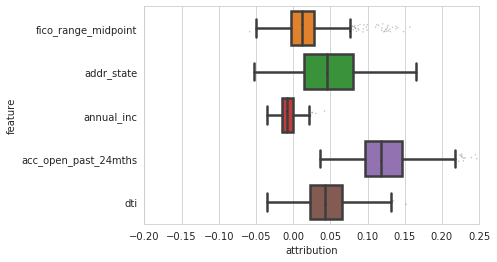

In [15]:
high_income_mask = x_test['annual_inc'] > 250_000
print('high income, high income accepted:', high_income_mask.sum(), (high_income_mask & accepted_mask).sum())
rich_accepted_sample = x_test[high_income_mask & accepted_mask]

phi_0, phi = multi_shapley_values(model_fn, model_input, rich_accepted_sample)
phi_0_accepted_rich, phi_accepted_rich = phi_0, phi
# result_plots(phi_0, phi, fig_path=figures_dir, figname='loans_vs_high_income_accepted')

plot_phi(phi)
plt.xlim(-.2, .25)

display(phi.agg(['mean', 'std']).style.set_caption('Mean Attributions'))

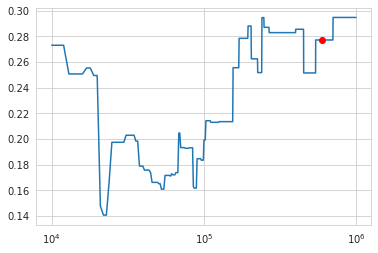

In [16]:
# understand how income affects prediction for this individual
different_incomes = pd.concat([model_input for _ in range(1_000)])
different_incomes['annual_inc'] = np.linspace(1e4, 1e6, 1_000)
plt.plot(different_incomes['annual_inc'], model_fn(different_incomes))
plt.plot(model_input['annual_inc'], model_fn(model_input), 'ro')
plt.xscale('log')

In [17]:
comparison_df = pd.DataFrame([phi_marginal.mean(), phi_accepted.mean(), phi_accepted_rich.mean()])
comparison_df.insert(0, 'phi_0', [phi_0_marginal.mean()[0], phi_0_accepted.mean()[0], phi_0_accepted_rich.mean()[0]])
comparison_df.index = ['Input Distribution', 'Accepted', 'Accepted & Income > $250k']
comparison_df.index.name = 'reference'
comparison_df.round(2)

,phi_0,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
reference,,,,,,
Input Distribution,0.14,0.00,0.03,0.00,0.10,-0.00
Accepted,0.05,0.02,0.04,0.02,0.11,0.03
Accepted & Income > $250k,0.05,0.02,0.05,-0.01,0.12,0.05


# Compare against uniform distribution
Here is an example of how when one feature is very predictive but almost always missing, the uniform distribution can really cause that feature to dominate. Identifying this sensitivity can definitely be helpful, though, and it is very faithful to the model. Intuitively, the `capitalgain` feature is the most important to the model when we ignore its rarity in the data.

pre-computing payout functions...


100%|██████████| 10000/10000 [00:00<00:00, 14847.16it/s]


computing shapley values...


100%|██████████| 10000/10000 [00:07<00:00, 1368.67it/s]


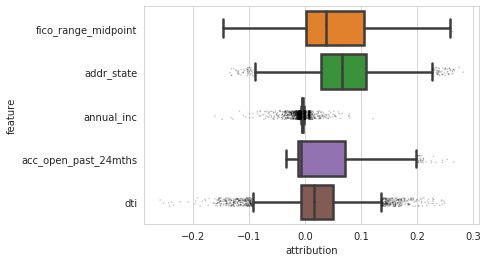

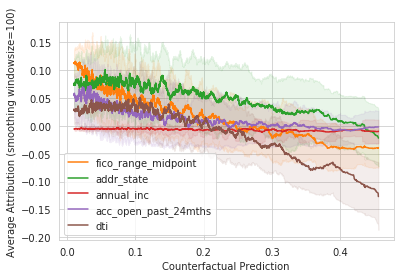

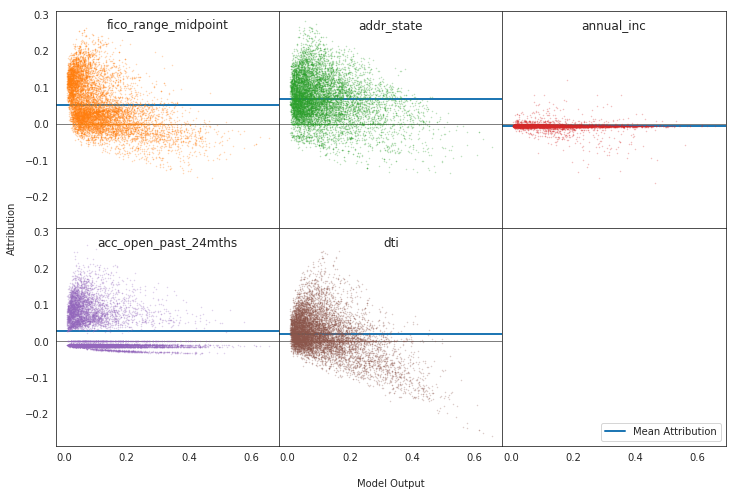

,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
mean,0.0517956,0.0684196,-0.00567414,0.0290796,0.0196579
std,0.0663301,0.0603998,0.00771109,0.0546706,0.0547677


In [18]:
# sample randomly in each column from possible ranges
sample_dict = dict()
rng = np.random.RandomState(0)
for column_name, column in x_test.iteritems():
    if column.dtype.name == 'category':
        sample_dict[column_name] = rng.choice(column.unique(), 10_000)
    else:
        sample_dict[column_name] = rng.choice(np.linspace(*column.agg(['min','max']), num=10_000), 10_000)

# build a dataframe with matching datatypes
uniform_sample_df = pd.DataFrame(sample_dict)
for column_name in x_test:
    uniform_sample_df[column_name] = uniform_sample_df[column_name].astype(x_test[column_name].dtype)

phi_0, phi = multi_shapley_values(model_fn, model_input, uniform_sample_df)
phi_0_unif, phi_unif = phi_0, phi # save

result_plots(phi_0, phi, fig_path=figures_dir, figname='loans_uniform')

display(phi.agg(['mean', 'std']).style.set_caption('Mean Attributions'))

In [19]:
phi_0.mean()

phi_0    0.113905
dtype: float64

# Joint marginal
If the dataset has high correlations, we might consider building a joint-marginal distribution. Let's look at the correlation matrix.

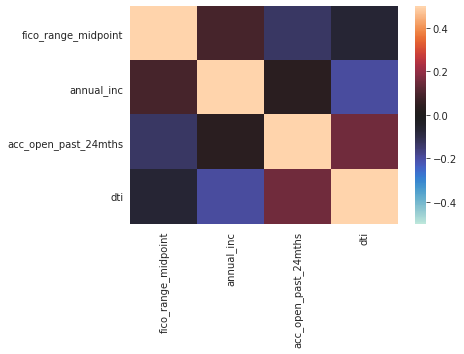

In [20]:
sns.heatmap(x_test.corr(), vmin=-0.5, vmax=0.5, center=0)

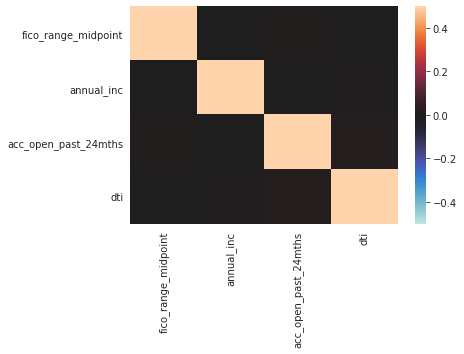

In [21]:
# sample randomly in each column separately
sample_dict = dict()
rng = np.random.RandomState(0)
for column_name, column in x_test.iteritems():
    sample_dict[column_name] = rng.choice(column.values, 10_000)

# build a dataframe with matching datatypes
jm_sample_df = pd.DataFrame(sample_dict)
for column_name in x_test:
    jm_sample_df[column_name] = jm_sample_df[column_name].astype(x_test[column_name].dtype)

# show how correlation has been mitigated
sns.heatmap(jm_sample_df.corr(), vmin=-0.5, vmax=0.5, center=0)

In [38]:
phi_0, phi = multi_shapley_values(model_fn, model_input, jm_sample_df)
phi_0_jm, phi_jm = phi_0, phi # save


display(phi.agg(['mean', 'std']).style.set_caption('Mean Attributions'))

pre-computing payout functions...


100%|██████████| 10000/10000 [00:00<00:00, 10958.21it/s]


computing shapley values...


100%|██████████| 10000/10000 [00:08<00:00, 1163.10it/s]


,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
mean,0.00506603,0.0304508,0.00519278,0.100585,-0.00313071
std,0.0229875,0.0350188,0.0289798,0.032739,0.0391208


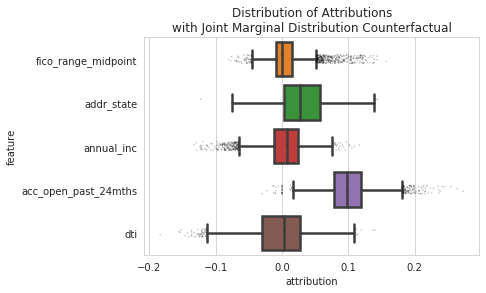

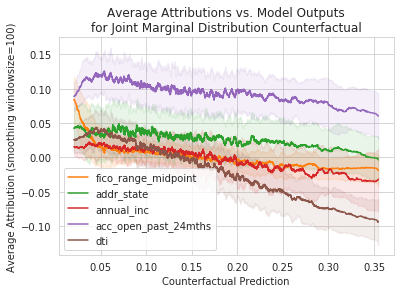

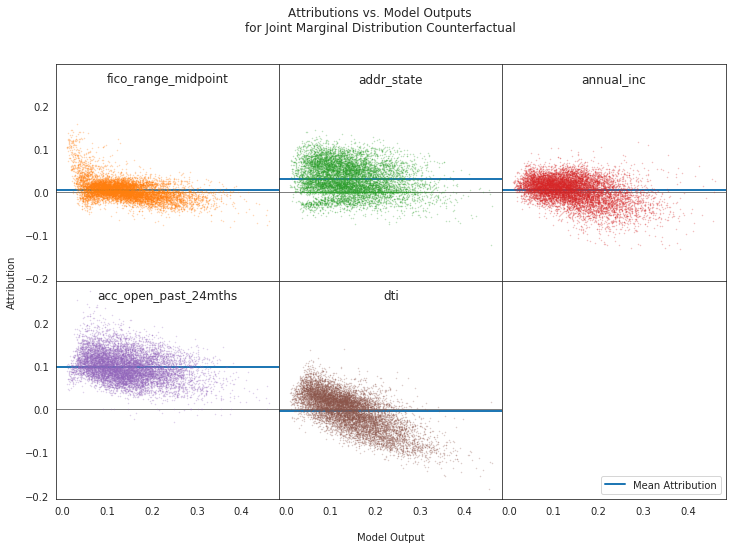

In [55]:
result_plots(phi_0, phi, 'Joint Marginal Distribution', fig_path=figures_dir, figname='loans_joint_marginal')

In [41]:
pd.DataFrame([phi_marginal.mean().values / np.abs(phi_marginal.mean().values).sum(), 
              phi.mean().values / np.abs(phi.mean().values).sum()], 
             index=['Marginal (normalized)', 'Joint Marginal (normalized)'],
             columns=x_test.columns)

,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
Marginal (normalized),0.030291,0.215329,0.031015,0.703890,-0.019476
Joint Marginal (normalized),0.035077,0.210841,0.035955,0.696449,-0.021677


In [42]:
# print $\phi_0$
print(phi_0_marginal.mean())
print(phi_0_jm.mean())
print(phi_0_unif.mean())

phi_0    0.141443
dtype: float64
phi_0    0.13902
dtype: float64
phi_0    0.113905
dtype: float64


# Clustering

We'll start by seeing how big groups are when clustered by vanilla k-means.

In [50]:
phi = phi_marginal
phi_0 = phi_0_marginal
k = 5
kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(phi)
cluster_ids = kmeans.predict(phi) + 1

print('Cluster ranges:')
pd.Series(model_fn(x_test_sample)).groupby(cluster_ids).agg(['min', 'max']).style.format('{:.3f}')

Cluster ranges:


,min,max
1,0.011,0.304
2,0.009,0.314
3,0.027,0.414
4,0.035,0.458
5,0.074,0.461


In [51]:
# project to 2-dimension via PCA to visualize 
pca = sklearn.decomposition.PCA(n_components=2).fit(phi)
two_dim_phi = pd.DataFrame(pca.transform(phi), columns=['pca_1', 'pca_2'])
print(f'Explained variance: {pca.explained_variance_ratio_.sum():.2f}')
pd.DataFrame(pca.components_, columns=phi.columns, index=['pca_1', 'pca_2'])

Explained variance: 0.64


,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
pca_1,-0.179192,0.336292,-0.207832,-0.182689,-0.882173
pca_2,0.064891,0.693858,-0.149569,-0.572577,0.405136


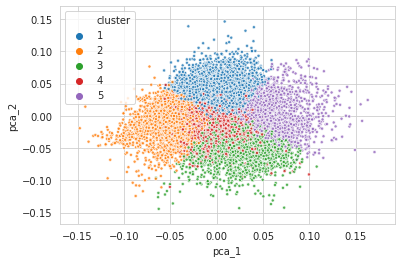

In [52]:
# plot results
two_dim_phi['cluster'] = cluster_ids
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', palette=sns.color_palette()[:k], data=two_dim_phi, s=10, alpha=0.8)
plt.savefig(figures_dir / 'loans_pca_cluster.png', bbox_inches='tight')
plt.show()

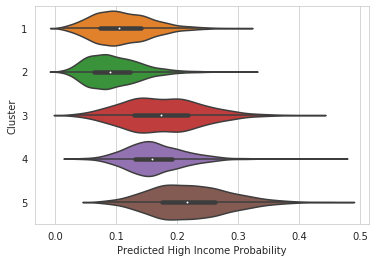

In [53]:
pred_by_cluster = pd.DataFrame({'Predicted High Income Probability': y_hat_test_sample, 'Cluster': cluster_ids}).sort_values(by='Cluster')
pred_by_cluster['Cluster'] = pred_by_cluster['Cluster'].astype('category')
sns.violinplot(x='Predicted High Income Probability', y='Cluster', data=pred_by_cluster, scale='width', palette=sns.color_palette()[1:])

# pred_by_cluster = pd.DataFrame(dict(counterfactual_pred=model_fn(x_test), cluster=[f'cluster_{i}' for i in cluster_ids]))
# sns.violinplot(x='counterfactual_pred', y='cluster', data=pred_by_cluster, scale='width')
# plt.title('Model prediction ranges for each cluster')
plt.savefig(figures_dir / 'loans_cluster_violin.png', bbox_inches='tight')
plt.show()

In [54]:
def ci_95(series):
    return 1.96 * series.std() / np.sqrt(series.shape[0])

# display details of clusters
grouped = phi.groupby(two_dim_phi['cluster'].values)
# groupwise_explanations = grouped.agg(['mean', 'std', ci_95]).round(4)
groupwise_explanations = grouped.agg(['mean']).round(2)
groupwise_explanations['total_delta'] = grouped.mean().sum(axis=1)
groupwise_explanations.insert(0, 'cluster_size', grouped.size().div(phi.shape[0]).apply(lambda x: f'{x:.1%}'))
groupwise_explanations.insert(0, 'avg_pred', phi_0.groupby(two_dim_phi['cluster'].values).mean().round(2))
print('model pred:', model_fn(model_input))
display(groupwise_explanations)

model pred: [0.277184]


,avg_pred,cluster_size,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti,total_delta
,,,mean,mean,mean,mean,mean,
1,0.11,28.5%,0.01,0.06,-0.00,0.08,0.01,0.167582
2,0.10,24.4%,0.01,0.00,0.01,0.11,0.04,0.181776
3,0.18,15.4%,0.00,0.01,-0.00,0.14,-0.05,0.101334
4,0.16,17.6%,-0.01,0.01,0.03,0.09,-0.01,0.114025
5,0.22,14.0%,-0.01,0.05,-0.02,0.08,-0.06,0.056012


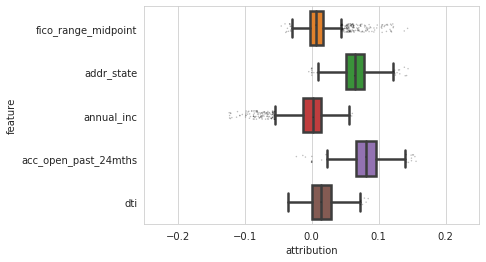

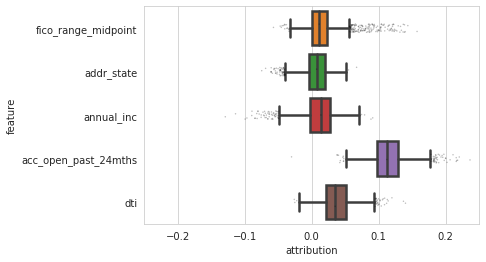

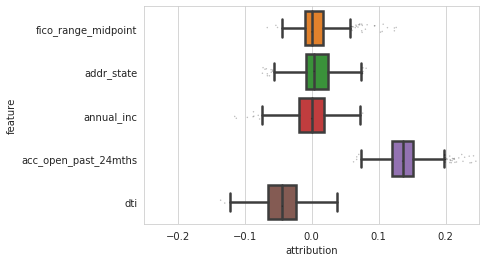

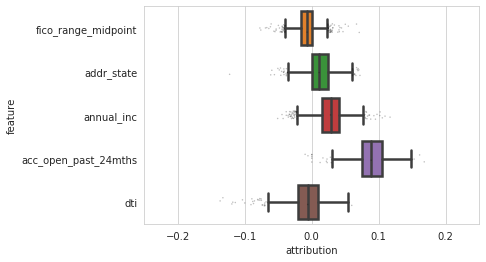

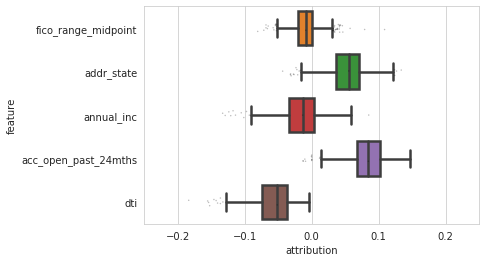

In [30]:
for i, group in grouped:
    plot_phi(group)
#     plt.title(f'Attributions vs cluster {i} ({group.shape[0]/phi.shape[0]:.1%} of data, avg_pred={groupwise_explanations.loc[i, "avg_pred"][0]:.2f})')
    plt.xlim(-.25, .25)
    plt.savefig(figures_dir / f'loans_cluster_{i}.png', bbox_inches='tight')
    plt.show()

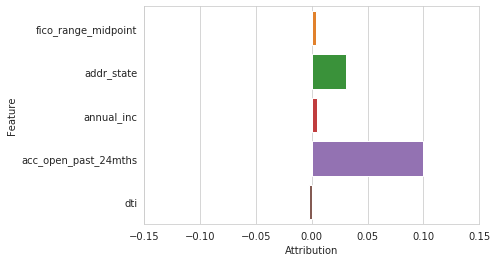

In [31]:
# mean of marginal attributions for comparison
sns.barplot(x=0, y='index', data=pd.Series(phi_marginal.mean(), index=phi_marginal.columns).reset_index(), palette=sns.color_palette()[1:])
plt.xlim(-.15, .15)
plt.ylabel('Feature')
plt.xlabel('Attribution')
plt.title(None)
f.savefig(figures_dir / 'loans_shap_values_barplot.png', bbox_inches='tight')
plt.show()

# Cluster explanations:
0. some points have relationship, education, and marital status that cause better scores (score ~.67)
1. many points are similar, scoring about the same
2. a small slice of points have much better capitalgain, achieving almost perfect scores (score ~.99)
3. some points have worse education, but better marital status and relationship, achieving higher but still low scores (score ~.32)

# Takeaways
Our individual could get a higher score in a number of ways. An almost-perfect score could come from improving capitalgain, and a moderate score from improving marital status, education, and relationship.

# Confidence Intervals

In [32]:
phi_0.groupby(two_dim_phi['cluster']).apply(ci_95)

""
cluster


In [33]:
marg_table = phi_marginal.agg(['mean', 'std', ci_95])
marg_table.insert(0, 'avg_pred', phi_0_marginal.agg(['mean', 'std', ci_95]))

accepted_table = phi_accepted.agg(['mean', 'std', ci_95])
accepted_table.insert(0, 'avg_pred', phi_0_accepted.agg(['mean', 'std', ci_95]))

# jm_table = phi_jm.agg(['mean', 'std', ci_95])
# jm_table.insert(0, 'avg_pred', phi_0_jm.agg(['mean', 'std', ci_95]))

# unif_table = phi_unif.agg(['mean', 'std', ci_95])
# unif_table.insert(0, 'avg_pred', phi_0_unif.agg(['mean', 'std', ci_95]))

for table in (marg_table, accepted_table):
    display(table.round(4))

,avg_pred,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
mean,0.1414,0.0043,0.0304,0.0044,0.0994,-0.0028
std,0.0686,0.0225,0.0351,0.0286,0.0320,0.0413
ci_95,0.0013,0.0004,0.0007,0.0006,0.0006,0.0008


,avg_pred,fico_range_midpoint,addr_state,annual_inc,acc_open_past_24mths,dti
mean,0.0509,0.0224,0.0390,0.0167,0.1137,0.0343
std,0.0138,0.0338,0.0367,0.0192,0.0288,0.0258
ci_95,0.0003,0.0007,0.0007,0.0004,0.0006,0.0005


In [34]:
# get the quantile of the average uniform prediction
(y_hat_test < phi_0_unif.mean()[0]).mean()

0.38987522581187245

In [35]:
phi_marginal.mean()

fico_range_midpoint     0.004278
addr_state              0.030414
annual_inc              0.004381
acc_open_past_24mths    0.099419
dti                    -0.002751
dtype: float64

In [36]:
phi_marginal.sample(30, random_state=0).mean()

fico_range_midpoint     0.005760
addr_state              0.032397
annual_inc              0.011456
acc_open_past_24mths    0.103861
dti                    -0.007238
dtype: float64

In [37]:
phi_marginal.sample(30, random_state=0).apply(ci_95)

fico_range_midpoint     0.006366
addr_state              0.014812
annual_inc              0.009482
acc_open_past_24mths    0.011919
dti                     0.017349
dtype: float64